# Bangla Article Classification With TF-Hub

## Setup

In [2]:
%%bash
# https://github.com/pypa/setuptools/issues/1694#issuecomment-466010982
pip install gdown --no-use-pep517

In [3]:
%%bash
# sudo apt-get install -y unzip

In [4]:
import os

import tensorflow as tf
import tensorflow_hub as hub

import gdown
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
gdown.download(
    url='https://drive.google.com/uc?id=1Ag0jd21oRwJhVFIBohmX_ogeojVtapLy',
    output='bard.zip',
    quiet=True
)

'bard.zip'

In [6]:
%%bash
unzip -qo bard.zip

# Export pretrained word vectors to TF-Hub module

TF-Hub provides some useful scripts for converting word embeddings to TF-hub text embedding modules [here](https://github.com/tensorflow/hub/tree/master/examples/text_embeddings_v2). To make the module for Bangla or any other languages, we simply have to download the word embedding `.txt` or `.vec` file to the same directory as `export_v2.py` and run the script.


The exporter reads the embedding vectors and exports it to a Tensorflow [SavedModel](https://www.tensorflow.org/beta/guide/saved_model). A SavedModel contains a complete TensorFlow program including weights and graph. TF-Hub can load the SavedModel as a [module](https://www.tensorflow.org/hub/api_docs/python/hub/Module), which we will use to build the model for text classification. Since we are using `tf.keras` to build the model, we will use [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer), which provides a wrapper for a TF-Hub module to use as a Keras Layer.

First we will get our word embeddings from fastText and embedding exporter from TF-Hub [repo](https://github.com/tensorflow/hub).


In [7]:
%%bash
curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
gunzip -qf cc.bn.300.vec.gz --k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  840M  100  840M    0     0  9149k      0  0:01:34  0:01:34 --:--:-- 8327k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7500  100  7500    0     0  23998      0 --:--:-- --:--:-- --:--:-- 24429


Then, we will run the exporter script on our embedding file. Since fastText embeddings have a header line and are pretty large (around 3.3 GB for Bangla after converting to a module) we ignore the first line and export only the first 100, 000 tokens to the text embedding module.

In [8]:
%%bash
python3 export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

2023-03-01 18:44:07.459567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 18:44:22.439042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:tensorflow:Assets written to: text_module/assets
I0301 18:44:24.391066 140704530024064 builder_impl.py:797] Assets written to: text_module/assets


In [9]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

2023-03-01 18:44:25.008556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The text embedding module takes a batch of sentences in a 1D tensor of strings as input and outputs the embedding vectors of shape (batch_size, embedding_dim) corresponding to the sentences. It preprocesses the input by splitting on spaces. Word embeddings are combined to sentence embeddings with the `sqrtn` combiner(See [here](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup_sparse)). For demonstration we pass a list of Bangla words as input and get the corresponding embedding vectors.

In [10]:
embedding_layer(['বাস', 'বসবাস', 'ট্রেন', 'যাত্রী', 'ট্রাক']) 

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[ 0.0462, -0.0355,  0.0129, ...,  0.0025, -0.0966,  0.0216],
       [-0.0631, -0.0051,  0.085 , ...,  0.0249, -0.0149,  0.0203],
       [ 0.1371, -0.069 , -0.1176, ...,  0.029 ,  0.0508, -0.026 ],
       [ 0.0532, -0.0465, -0.0504, ...,  0.02  , -0.0023,  0.0011],
       [ 0.0908, -0.0404, -0.0536, ..., -0.0275,  0.0528,  0.0253]])>

# Convert to Tensorflow Dataset 


Since the dataset is really large instead of loading the entire dataset in memory we will use a generator to yield samples in run-time in batches using [Tensorflow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) functions. The dataset is also very imbalanced, so, before using the generator, we will shuffle the dataset. 


In [11]:
dir_names = ['economy', 'sports', 'entertainment', 'state', 'international']

file_paths = []
labels = []
for i, dir in enumerate(dir_names):
  file_names = ["/".join([dir, name]) for name in os.listdir(dir)]
  file_paths += file_names
  labels += [i] * len(os.listdir(dir))
  
np.random.seed(42)
permutation = np.random.permutation(len(file_paths))

file_paths = np.array(file_paths)[permutation]
labels = np.array(labels)[permutation]

We can check the distribution of labels in the training and validation examples after shuffling.

In [12]:
train_frac = 0.8
train_size = int(len(file_paths) * train_frac)

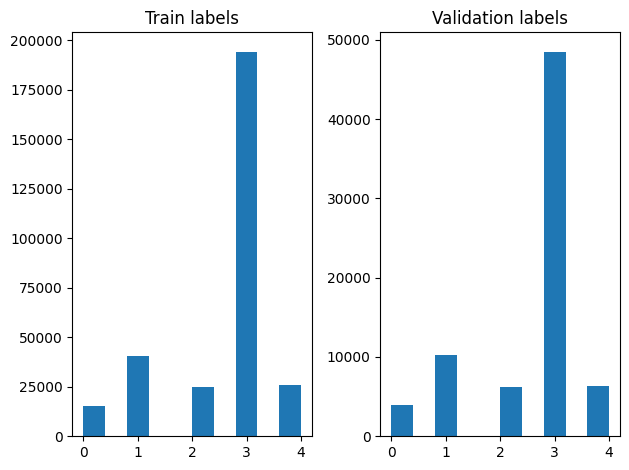

In [13]:
# plot training vs validation distribution
plt.subplot(1, 2, 1)
plt.hist(labels[0:train_size])
plt.title("Train labels")
plt.subplot(1, 2, 2)
plt.hist(labels[train_size:])
plt.title("Validation labels")
plt.tight_layout()

To create a [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) using a generator, we first write a generator function which reads each of the articles from `file_paths` and the labels from the label array, and yields one training example at each step. We pass this generator function to the [`tf.data.Dataset.from_generator`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) method and specify the output types. Each training example is a tuple containing an article of `tf.string` data type and one-hot encoded label. We split the dataset with a train-validation split of 80-20 using [`tf.data.Dataset.skip`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip) and [`tf.data.Dataset.take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) methods.

In [14]:
def load_file(path, label):
    return tf.io.read_file(path), label

In [15]:
def make_datasets(train_size):
  batch_size = 256

  train_files = file_paths[:train_size]
  train_labels = labels[:train_size]
  train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
  train_ds = train_ds.map(load_file).shuffle(5000)
  train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  test_files = file_paths[train_size:]
  test_labels = labels[train_size:]
  test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
  test_ds = test_ds.map(load_file)
  test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


  return train_ds, test_ds

In [16]:
train_data, validation_data = make_datasets(train_size)

# Model Training and Evaluation

## Model

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string),
    embedding_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(5),
  ])
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer="adam", metrics=['accuracy'])


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Build the mechanized model

In [18]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism

mechanized_model = MechanizedSequential(
        [
        tf.keras.layers.Input(shape=[], dtype=tf.string),
        embedding_layer,
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(5),
    ]
    )
mechanized_model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam", metrics=['accuracy'],
    run_eagerly = True)
mechanized_model.summary()


Model: "mechanized_sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 300)               30000300  
                                                                 
 dense_3 (Dense)             (None, 64)                19264     
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 5)                 85        
                                                                 
Total params: 30,020,689
Trainable params: 20,389
Non-trainable params: 30,000,300
_________________________________________________________________


In [19]:
# Create earlystopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

## Training

In [20]:
mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_mechanism_para(sigma = 0.1)

gaussian_history = mechanized_model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs = 3, 
                    callbacks=[early_stopping_callback])

Epoch 1/3
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
Cannot create Gaussian noise for non-numeric data
   1/1176 [..............................] - ETA: 13:23 - loss: 1.5880 - accuracy: 0.2734In Gaussian Mechanism
Create Gaussian noise when accessing the training data
Cannot create Gaussian noise for non-numeric data
   2/1176 [..............................] - ETA: 4:18 - loss: 1.5570 - accuracy: 0.4062 In Gaussian Mechanism
Create Gaussian noise when accessing the training data
Cannot create Gaussian noise for non-numeric data
   3/1176 [..............................] - ETA: 4:25 - loss: 1.5160 - accuracy: 0.4805In Gaussian Mechanism
Create Gaussian noise when accessing the training data
Cannot create Gaussian noise for non-numeric data
   4/1176 [..............................] - ETA: 4:21 - loss: 1.4824 - accuracy: 0.5273In Gaussian Mechanism
Create Gaussian noise when accessing the training data
Cannot create Gaussian noise for non-numeric data
 

In [ ]:
gaussian_y_pred = model.predict(validation_data)
gaussian_y_pred = np.argmax(gaussian_y_pred, axis=1)

In [ ]:
mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.5, threshold = 0.5)

threshold_history = mechanized_model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs = 3, 
                    callbacks=[early_stopping_callback])

In [ ]:
threshold_y_pred = model.predict(validation_data)
threshold_y_pred = np.argmax(threshold_y_pred, axis=1)

In [ ]:
empirical_history = model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs = 3, 
                    callbacks=[early_stopping_callback])

In [ ]:
empirical_y_pred = model.predict(validation_data)
empirical_y_pred = np.argmax(threshold_y_pred, axis=1)

## Evaluation

We can visualize the accuracy and loss curves for training and validation data using the `tf.keras.callbacks.History` object returned by the `tf.keras.Model.fit` method, which contains the loss and accuracy value for each epoch.

In [ ]:
# Plot training & validation accuracy values
def loss_acc_lpot(history, mechanism):
    history = history
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train-' + mechanism, 'Test-'+mechanism], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train-' + mechanism, 'Test-'+mechanism], loc='upper left')

In [ ]:
plt.figure()
loss_acc_lpot(empirical_history, "Baseline")
loss_acc_lpot(gaussian_history, "Gaussian")
loss_acc_lpot(threshold_history, "Threshold")
plt.show()

## Prediction

We can get the predictions for the validation data and check the confusion matrix to see the model's performance for each of the 5 classes. Because `tf.keras.Model.predict` method returns an n-d array for probabilities for each class, they can be converted to class labels using `np.argmax`.

In [32]:
y_true = np.array(labels[train_size:])

In [33]:
print("Baseline evaluation report:", classification_report(y_true, empirical_y_pred, target_names=dir_names))


               precision    recall  f1-score   support

      economy       0.79      0.81      0.80      3897
       sports       0.99      0.98      0.98     10204
entertainment       0.91      0.94      0.93      6256
        state       0.97      0.97      0.97     48512
international       0.93      0.93      0.93      6377

     accuracy                           0.96     75246
    macro avg       0.92      0.93      0.92     75246
 weighted avg       0.96      0.96      0.96     75246



In [ ]:
print("Gaussian evaluation report:", classification_report(y_true, gaussian_y_pred, target_names=dir_names))


In [ ]:
print("Threshold evaluation report:", classification_report(y_true, threshold_y_pred, target_names=dir_names))
